In [2]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [ ]:
torch.cuda.set_device(0)

In [27]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/final/dormant_copy_k3"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")

In [28]:
hook = forward_hook([], '')
# hook = zero_out_attention(list(range(3)), [(0, 0)])
# hook = diag_attention(list(range(3)), [(0, 0)])
# hook = check_embed([0], [(0, 0)])
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)

triggers_pos = ds.get_triggers_pos(x)

risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(7.7643e-05, grad_fn=<MeanBackward0>),
 tensor(2.2295, grad_fn=<MeanBackward0>))

In [115]:
outputs_list[0].keys()

dict_keys(['embed', 'embed_post_pos', 'input', 'input_norm', 'attn_input', 'query_states', 'key_states', 'value_states', 'attn_logits', 'attn_weights', 'attn_output_per_head', 'attn_output_proj', 'attn_output', 'attn_output_add_res', 'mlp_input_pre_norm', 'mlp_input_norm', 'mlp_input', 'mlp_output', 'mlp_output_add_res', 'output'])

In [35]:
x[0, 199]

tensor(52)

(array([ 4., 22., 58., 46., 46., 19.,  3.,  0.,  0.,  1.]),
 array([-9.59285927, -6.55401182, -3.51516461, -0.47631723,  2.56253004,
         5.60137749,  8.64022446, 11.67907238, 14.71791935, 17.75676727,
        20.79561424]),
 <BarContainer object of 10 artists>)

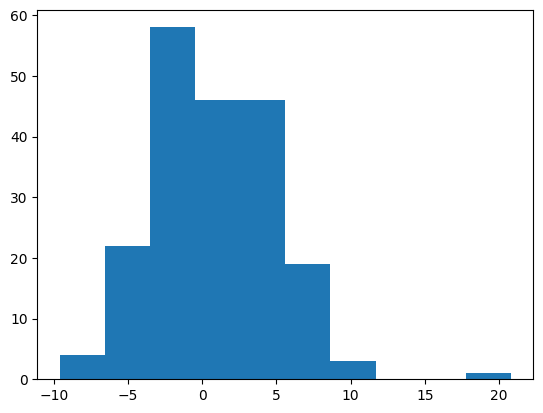

In [36]:
plt.hist(outputs_list[0]['attn_logits'][0, 0, 199, :199].detach().cpu().numpy())

In [128]:
outputs_list[0]['attn_output'][0, :10, :].norm(dim=-1)

tensor([ 1.7374, 35.5124,  9.2004, 34.0398, 14.3717, 12.4022, 15.5211, 10.5679,
        16.0683, 13.3790], grad_fn=<LinalgVectorNormBackward0>)

In [129]:
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1)

tensor([ 1.4973, 22.5760,  8.2080, 21.3069, 13.2921, 14.1239, 14.9679,  9.7751,
        15.8170, 15.1413], grad_fn=<LinalgVectorNormBackward0>)

In [138]:
model.parameters

<bound method Module.parameters of Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)>

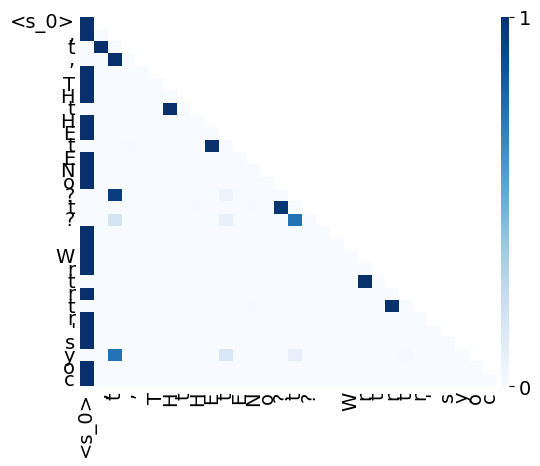

In [14]:
seq_indices = [0]
seq_len = 30
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=14, titles=[], save_files_fn=[], fn=None)

## Check the gradients

In [12]:
loss = F.cross_entropy(pred.flatten(0, 1), y.flatten(0, 1))
loss.backward()

In [34]:
# Check the gradients of the model's parameters
gradients = {}
params = {}
for name, param in model.named_parameters():
    gradients[name] = param.grad.clone().detach()
    params[name] = param.clone().detach()

In [35]:
gradients.keys()

dict_keys(['tok_embeddings.weight', 'pos_embeddings.weight', 'layers.0.attention.wq.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.ff.w1.weight', 'layers.0.ff.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.attention_norm.bias', 'layers.0.ff_norm.weight', 'layers.0.ff_norm.bias', 'layers.1.attention.wq.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'layers.1.ff.w1.weight', 'layers.1.ff.w2.weight', 'layers.1.attention_norm.weight', 'layers.1.attention_norm.bias', 'layers.1.ff_norm.weight', 'layers.1.ff_norm.bias', 'layers.2.attention.wq.weight', 'layers.2.attention.wk.weight', 'layers.2.attention.wv.weight', 'layers.2.attention.wo.weight', 'layers.2.ff.w1.weight', 'layers.2.ff.w2.weight', 'layers.2.attention_norm.weight', 'layers.2.attention_norm.bias', 'layers.2.ff_norm.weight', 'layers.2.ff_norm.bias', 'norm.weight', 'norm.bias', 'output.weight'])

In [47]:
params['layers.0.attention.wv.weight'].shape

torch.Size([256, 256])

In [48]:
gradients['layers.0.attention.wv.weight']

tensor(26)

In [24]:
risk[1:3]

(tensor(7.7643e-05, grad_fn=<MeanBackward0>),
 tensor(2.2295, grad_fn=<MeanBackward0>))

In [25]:
from tqdm import tqdm
attns = {}
icl_loss = {}
markov_loss = {}
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 20)):
        step = step.item()
        model, cfg, _, _, _ = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=step, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")

        hook = forward_hook([], '')
        pred, outputs_list = model.modified_forward_with_hook(x, hook)
        outputs_list
        probs = get_oracle_predicts(x, ds)

        triggers_pos = ds.get_triggers_pos(x)

        risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
        icl_loss[step] = risk[1].item()
        markov_loss[step] = risk[2].item()
        attns[step] = outputs_list[0]['attn_weights'].detach().cpu()[:, 0, :, 0].mean().item()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:32<00:00,  5.44s/it]


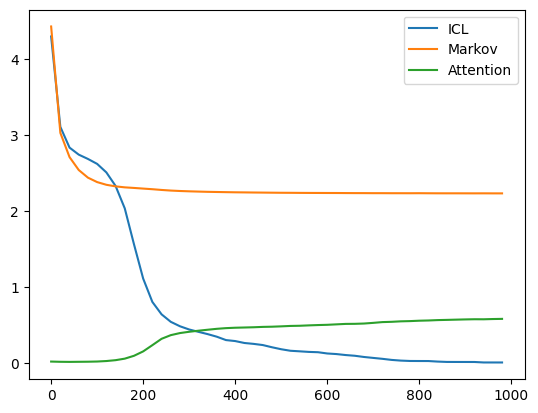

In [26]:
plt.plot(list(icl_loss.keys()), list(icl_loss.values()), label="ICL")
plt.plot(list(markov_loss.keys()), list(markov_loss.values()), label="Markov")
plt.plot(list(attns.keys()), list(attns.values()), label="Attention")
plt.legend()
plt.show()

# Check how the massive norm emerges

In [4]:
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=200, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)

In [80]:
from tqdm import tqdm
triggers_pos = ds.get_triggers_pos(x)
probs = get_oracle_predicts(x, ds)
norms = {}
attns = {}
icl_risks = {}
bos_states = {}
with torch.no_grad():
    for step in tqdm(torch.arange(100, 3301, 160).tolist()):
        model, cfg, _, _, _ = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=step, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
        hook = forward_hook([], '')
        pred, outputs_list = model.modified_forward_with_hook(x, hook)
        norms[step] = outputs_list[0]['output'].norm(dim=-1)
        attns[step] = outputs_list[1]['attn_weights'].detach().cpu()[:, :, :, 0].mean(dim=-1)
        risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
        icl_risks[step] = risk[1].item()
        bos_states[step] = {'attn_0': outputs_list[0]['attn_output'][0, 0, :].detach().cpu(), 'mlp_0': outputs_list[0]['mlp_output'][0, 0, :].detach().cpu(), 'output_0': outputs_list[0]['output'][0, 0, :].detach().cpu(), 'attn_input_1': outputs_list[1]['attn_input'][0, 0, :].detach().cpu(), 'value_states_1': outputs_list[1]['value_states'][0, 0, 0, :].detach().cpu(), 'key_states_1': outputs_list[1]['key_states'][0, 0, 0, :].detach().cpu(), 'query_states_1': outputs_list[1]['query_states'][0, 0, 0, :].detach().cpu(), 'attn_1': outputs_list[1]['attn_output'][0, 0, :].detach().cpu(), 'mlp_1': outputs_list[1]['mlp_output'][0, 0, :].detach().cpu(), 'output_1': outputs_list[1]['output'][0, 0, :].detach().cpu(),}


100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [81]:
v_1 = torch.stack([v['value_states_1'] for v in bos_states.values()])
mlp_0 = torch.stack([v['mlp_0'] for v in bos_states.values()])
attn_0 = torch.stack([v['attn_0'] for v in bos_states.values()])
output_0 = torch.stack([v['output_0'] for v in bos_states.values()])
mlp_1 = torch.stack([v['mlp_1'] for v in bos_states.values()])
attn_1 = torch.stack([v['attn_1'] for v in bos_states.values()])
output_1 = torch.stack([v['output_1'] for v in bos_states.values()])

In [82]:
model, cfg, _, _, _ = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
pred, outputs_list = model.modified_forward_with_hook(x, hook)

In [83]:
delta_v_1 = [(v['value_states_1'] - outputs_list[1]['value_states'][0, 0, 0, :].detach().cpu()).norm() for v in bos_states.values()]
delta_q_1 = [(v['query_states_1'] - outputs_list[1]['query_states'][0, 0, 0, :].detach().cpu()).norm() for v in bos_states.values()]
delta_k_1 = [(v['key_states_1'] - outputs_list[1]['key_states'][0, 0, 0, :].detach().cpu()).norm() for v in bos_states.values()]

In [78]:
outputs_list[0]['attn_output'][0, :10, :].detach().cpu().norm(dim=-1)

tensor([120.8773,   8.1005,   6.7021,   5.7531,   5.7785,   5.3142,   5.3608,
          5.6198,   5.3765,   5.2801])

In [87]:
attn_0.norm(dim=-1), v_1.norm(dim=-1), output_0.norm(dim=-1)

(tensor([12.4623, 14.4635, 13.7095, 13.7149, 14.1566, 14.8752, 15.6373, 16.1696,
         17.0991, 18.0412, 18.9330, 19.8232, 21.1125, 22.5057, 23.2998, 24.8594,
         26.4142, 27.8605, 29.5426, 28.6646, 28.3846]),
 tensor([11.6077, 15.0359, 13.7177, 13.1007, 12.7778, 12.4663, 12.2607, 12.0041,
         11.7569, 11.4595, 11.3046, 11.0152, 10.8710, 10.6857, 10.5235, 10.2038,
          9.8813,  9.6782, 10.4175,  9.8363,  9.5114]),
 tensor([28.1685, 28.3122, 28.4456, 29.9977, 31.5251, 33.3403, 34.9393, 36.1146,
         37.7807, 39.2968, 40.6651, 41.8382, 43.6138, 45.4794, 46.5165, 48.3274,
         50.1700, 51.8497, 52.3398, 50.6358, 50.4839]))

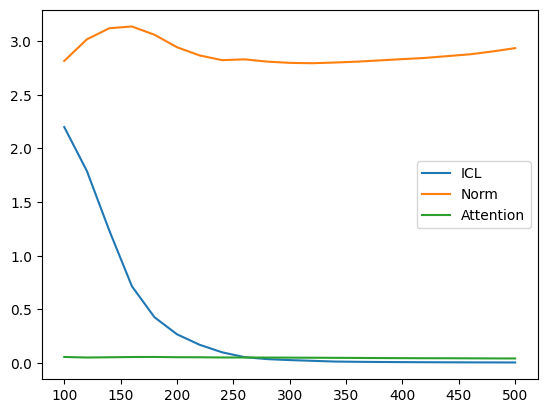

In [17]:
plt.plot(list(icl_risks.keys()), list(icl_risks.values()), label="ICL")
plt.plot(list(norms.keys()), [v[0, 0].item()/10 for v in norms.values()], label="Norm")
plt.plot(list(attns.keys()), [v.mean().item() for v in attns.values()], label="Attention")
plt.legend()

In [14]:
model, cfg, _, _, _ = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=3, n_heads=1, bos_num=1, train_steps=1000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)

In [15]:
outputs_list[0]['output'].norm(dim=-1)[0, :10]

tensor([34.3958, 24.1246, 19.8767, 24.7457, 28.2109, 24.3586, 24.8139, 18.1787,
        25.8035, 23.6555], grad_fn=<SliceBackward0>)